# Using LightGBM classifier on credit card user data to predict default rate

This notebook utilizes the LightGBM package by Microsoft with a clean dataset on credit card defaults (source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). Since we are trying to predict if a person is defaulting or not, we will want to use binary classification. This notebook also explores early stopping, a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration.

In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('ccdata.xls', header = 1)

In [ ]:
data.info()

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


In [3]:
data.drop('ID', axis = 1, inplace = True)

In [ ]:
# Check for null values. 
data.isnull().sum().sort_values(ascending=False)

Thank god there are no missing values! If there were, we would have to either drop the feature if 
there are more than 60% of the values are missing, or impute them. 

In [4]:
# Outlier Detection in this cell.
# For each column, first it computes the Z-score of each value in the column,
# relative to the column mean and standard deviation. Then is takes the absolute 
# of Z-score because the direction does not matter, only if it is below the threshold.
# all(axis=1) ensures that for each row, all column satisfy the constraint. 
data = data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [5]:
# Below, we separate our target variable from our dataset. 
X = data.drop(['default payment next month'], axis=1)
y = data['default payment next month']

In [6]:
# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

<h2>LightGBM classifier hyperparameter optimization via scikit-learn's GridSearchCV</h2>

In [ ]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(24,40,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
        ])



In [ ]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

<h2>LightGBM Hyperparameters + early stopping</h2>

In [30]:

gbm = lgb.LGBMClassifier(learning_rate = 0.15, metric = 'binary_error', 
                         reg_alpha = 0.1,
                         reg_lambda = 0.1,
                        n_estimators = 200,)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss','l1', 'l2'],
        callbacks=[
                lgb.early_stopping(stopping_rounds=5),
        ],
)


[LightGBM] [Info] Number of positive: 5030, number of negative: 17434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 22464, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223914 -> initscore=-1.243002
[LightGBM] [Info] Start training from score -1.243002
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.77497	valid_0's binary_logloss: 0.438562	valid_0's l1: 0.281158	valid_0's l2: 0.137763	valid_0's binary_error: 0.180328


LGBMClassifier(learning_rate=0.15, metric='binary_error', n_estimators=200,
               reg_alpha=0.1, reg_lambda=0.1)

<h2>Feature Importances Graph </h2>

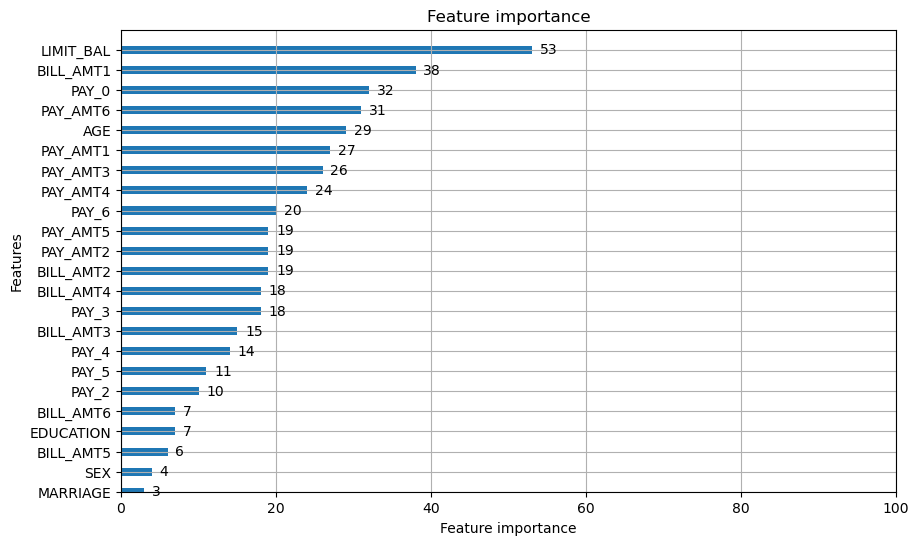

In [31]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()


<h2>Dimensionality reduction using feature importances</h2>

In [33]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[53,
 38,
 32,
 31,
 29,
 27,
 26,
 24,
 20,
 19,
 19,
 19,
 18,
 18,
 15,
 14,
 11,
 10,
 7,
 7,
 6,
 4,
 3]

In [34]:
# The code below aims to drop  to keep the features that are included in the most important features. 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    print(feature)
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

53
38
32
31
29
27
26
24
20
19
19
19
18
18
15
15 0.8622222222222222


In [35]:
#The above means let go of all variables after PAY_AMT_5
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0 = str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.7749700285270646


In [36]:
#We can choose to drop the last 6 features from in our new model to reduce dimensionality, and thus save training time and space

X = X.drop(['PAY_5','PAY_AMT4','BILL_AMT4','BILL_AMT2','BILL_AMT6','EDUCATION','BILL_AMT5','BILL_AMT3'], axis=1)

In [37]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=3),
        ]
        )
print('Best parameters found by grid search are:', gridsearch.best_params_)



[LightGBM] [Info] Number of positive: 4280, number of negative: 14748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 19028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224932 -> initscore=-1.237154
[LightGBM] [Info] Start training from score -1.237154
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.772414	valid_0's binary_logloss: 0.482576	valid_0's l1: 0.326741
[LightGBM] [Info] Number of positive: 4281, number of negative: 14748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

In [45]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss', 'binary_error'],
        callbacks=[
                lgb.early_stopping(stopping_rounds=3),
        ]
)

[LightGBM] [Info] Number of positive: 5351, number of negative: 18435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224964 -> initscore=-1.236968
[LightGBM] [Info] Start training from score -1.236968
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.772154	valid_0's binary_logloss: 0.507923	valid_0's binary_error: 0.220961	valid_0's l1: 0.338962


LGBMClassifier(metric='l1', n_estimators=20)

<li>We still need to compare the <b>classification accuracy </b> versus the <b>null accuracy</b> ( the accuracy that could be achieved by always predicting the most frequent class). We must always compare the two.  </li>

In [62]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))
pd.Series(y_pred).describe()

The accuracy of prediction is: 0.7790389708664397
The roc_auc_score of prediction is: 0.5
The null acccuracy is: 0.7790389708664396


count    2643.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [47]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]

In [48]:
y_pred_pro

array([0.21148627, 0.2314076 , 0.2191977 , ..., 0.22087094, 0.22318443,
       0.21148627])

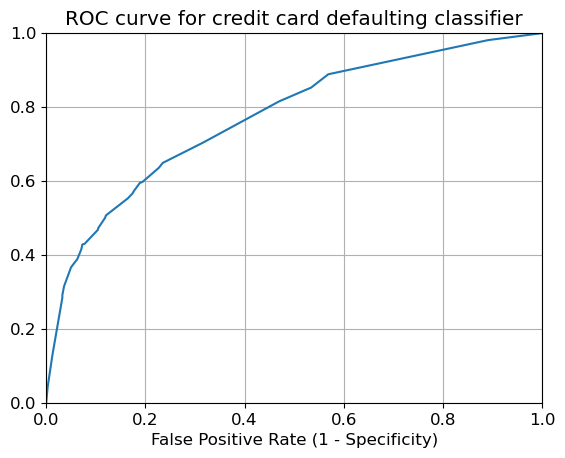

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [50]:
auc_roc_1 = str(roc_auc_score(y_test, y_pred_prob))
print('AUC with dimensionality reduction: \n' + auc_roc_1)
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.7721538251711497
AUC without dimensionality reduction: 
0.7749700285270646


<h2>Conclusion</h2>
We were able to reduce the size of our training/test set by 26% by removing 6 features, while only giving up 0.52% in our AUC accuracy



- AUC is useful as a single number summary of classifier performance
- Higher value means that it is a better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
- AUC is useful even when there is high class imbalance (unlike classification accuracy)



It is a good thing that the prediction accuracy is greater than the null accuracy because it shows us that the model is performing better than by just predicting the most frequent class. 

<h2>Confusion matrix </h2>

In [51]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[2059    0]
 [ 584    0]]




<b>Basic terminology</b>

- <b>True Positives (TP)</b>: we correctly predicted that they would default. 
    - 233
     
     
- <b>True Negatives (TN)</b>: we correctly predicted that they won't default.
    - 2252
     
    
- <b>False Positives (FP)</b>: we incorrectly predicted that they did default.
    - 108
    - Falsely predict positive
    - Type I error
      
       
- <b>False Negatives (FN)</b>: we incorrectly predicted that they didn't default. 
    - 407
    - Falsely predict negative
    - Type II error

